In [35]:
from skimage.morphology import skeletonize, thin, binary_erosion
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert
import imageio
from scipy import misc
from skimage import color
from skimage import measure
import sys


np.set_printoptions(threshold=sys.maxsize, linewidth=1000)

#Set up workspace
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import imageio
import pylab as plx

In [36]:
## Tommy's Utility Functions
#Ok, let's write a formula that can convert from color to bw/binary image
def make_bw(img,thresh=130):
    gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114]) 
    gray_img = gray(img)
    bw_img = bw_convert(gray_img,thresh)
    
    return bw_img


#Ok, let's convert the grayscale to a simple black-white: that may help us in observing the 
#"Fractal" structure (and other formal qualities)

def bw_convert(img,thresh):
    bw_pic = img.copy()
    bw_mask = bw_pic[:, :,] < thresh
    bw_pic[bw_mask] = 0
    bw_pic[~bw_mask] = 1
    return bw_pic


(335, 332, 3)
[ True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True False  True  True  True  True  True  True  True  True  

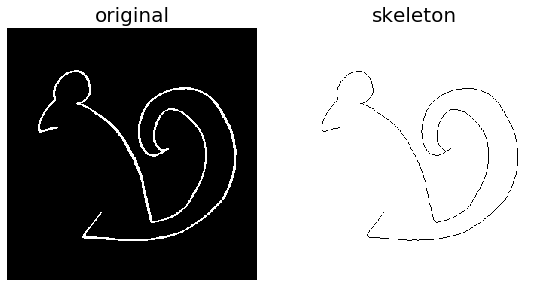

In [56]:
# Invert the horse image
squirrel = imageio.imread('images/squirrel.jpg') 
print(squirrel.shape)
squirrel_bw = invert(make_bw(squirrel))
skeleton = invert(thin(squirrel_bw))

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(squirrel_bw, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)
print(skeleton[150])

fig.tight_layout()
plt.show()

In [73]:
#raw_point_array[i] corresponds to ith point

def check_x_increasing(point1, point2): #point1 and point2 are [x1,y1], [y1,y2]
    if point1[0] < point2[0]:
        return True 
    else:
        return False
    
def process_point_array(raw_point_array):
    output = []
    cutoff_ind = [0]
    increasing_current = check_x_increasing(raw_point_array[0],raw_point_array[1])
    for point_idx in range(len(raw_point_array)): # point = [x_coord, y_coord]
        if point_idx !=len(raw_point_array)-1:
            if increasing_current !=check_x_increasing(raw_point_array[point_idx], raw_point_array[point_idx+1]):
                cutoff_ind.append(point_idx)
                increasing_current = not increasing_current
    cutoff_ind.append(len(raw_point_array)-1) #the last point
    
    for i in range(len(cutoff_ind)-1):
        output.append(raw_point_array[cutoff_ind[i]:cutoff_ind[i+1]+1])
        
    return output


In [8]:
print(skeleton.shape)

(328, 400)


In [81]:
contours_nd.shape[1] / 2

1588.5

In [197]:
# Contour tracing from this website: 
# http://freeconnection.blogspot.com/2013/07/vectorize-image-with-python-scikit-image.html
fimg = imageio.imread("images/squirrel.jpg")
gimg = color.colorconv.rgb2grey(fimg)
contours = measure.find_contours(gimg, 0.8)
contours = np.array(contours)
print(contours.shape)

# Do a 270 degree transformation on the points to rotate
def transform_points(coordinate_pair, rotation_matrix):
    result = np.matmul(rotation_matrix, coordinate_pair)
    return result

rotation_matrix = np.array([[0, 1], [-1, 0]])
contours = np.array([[transform_points(cp, rotation_matrix) for cp in contours[0]]])



(1, 3177, 2)


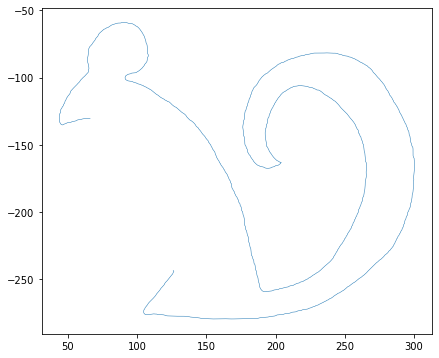

In [199]:
# Find approximately 50%
row_start = 1465
row_end = 3025

plt.figure(figsize=(7, 6))
for n, contour in enumerate(contours):
    plt.plot(contour[row_start:row_end, 0], contour[row_start:row_end, 1],  linewidth=0.5)


In [93]:
# Process so far: Use vectorization, grab roughly 50% of the line, since there's a start and end point

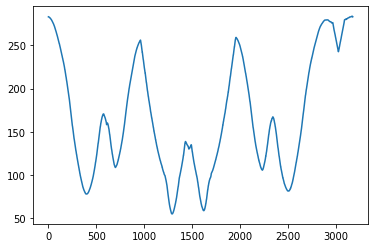

In [39]:
# To confirm that this is a continuous line that the vector gave us
plt.plot(contours_nd[0, :, 0])
plt.show()


In [40]:
# Now, let's try erosion via OpenCV
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html#morphological-ops

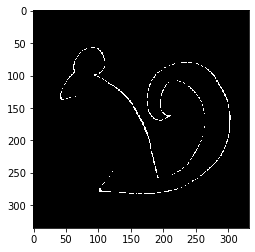

In [75]:
inverted_image = invert(make_bw(fimg))
eroded_image = binary_erosion(inverted_image)


plt.imshow(eroded_image, cmap=plt.cm.gray)

In [78]:
squirrel = imageio.imread('images/squirrel.jpg') 
squirrel_bw = invert(make_bw(squirrel))
skeleton = invert(thin(squirrel_bw))


contours_sk = measure.find_contours(skeleton, 0.8)
contours_nd_sk = np.array(contours_sk)

splited_skeleton = process_point_array(contours_nd_sk)


(335, 332)


IndexError: index 1 is out of bounds for axis 0 with size 1